# WDSR

In [1]:
#COLAB environment setup:
!pip install tensorflow-gpu==2.3.1 tensorflow-addons==0.11.2 ## replace to !pip install tensorflow for CPU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320.4 MB 24 kB/s 
     |████████████████████████████████| 1.1 MB 11.3 MB/s 
     |████████████████████████████████| 459 kB 72.0 MB/s 
     |████████████████████████████████| 2.9 MB 51.3 MB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      

In [2]:
!git clone https://github.com/IritaSee/super-resolution-colab.git

Cloning into 'super-resolution'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 408 (delta 0), reused 2 (delta 0), pack-reused 405
Receiving objects: 100% (408/408), 48.16 MiB | 40.52 MiB/s, done.
Resolving deltas: 100% (214/214), done.


In [3]:
%cd super-resolution

/content/super-resolution


In [1]:
!ls

article.ipynb		example_edsr.ipynb   README.md
data_engineering.ipynb	example_srgan.ipynb  train.py
data.py			example_wdsr.ipynb   utils.py
demo			LICENSE		     weights
docs			model		     weights-edsr-16-x4.tar.gz
environment.yml		__pycache__


In [19]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.wdsr import wdsr_b
from train import WdsrTrainer

%matplotlib inline

In [20]:
# Number of residual blocks
# depth = 32
depth = 16

# Super-resolution factor
scale = 4 #ini jangan di ganti, ngaruh ke dataset

# Downgrade operator
downgrade = 'bicubic'

In [21]:
# Location of model weights (needed for demo)
weights_dir = f'weights/wdsr-b-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights_16_as_depth.h5')

os.makedirs(weights_dir, exist_ok=True)

## Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
div2k_train = DIV2K(scale=scale, subset='train', downgrade=downgrade)
div2k_valid = DIV2K(scale=scale, subset='valid', downgrade=downgrade)

In [7]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

2022-12-22 00:11:28.810350: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-12-22 00:11:28.992793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 00:11:28.993561: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design computeCapability: 7.5
coreClock: 1.335GHz coreCount: 24 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 268.26GiB/s
2022-12-22 00:11:28.993670: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-12-22 00:11:29.668119: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-12-22 00:11:29.925693: I tensorflo

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-wdsr-b-32-x4.tar.gz](https://martin-krasser.de/sisr/weights-wdsr-b-32-x4.tar.gz) and extract the archive in the project's root directory. This will create a `weights/wdsr-b-32-x4` directory containing the weights of the pre-trained model.

In [9]:
!wget https://martin-krasser.de/sisr/weights-wdsr-b-32-x4.tar.gz

--2022-07-13 20:56:58--  https://martin-krasser.de/sisr/weights-wdsr-b-32-x4.tar.gz
Resolving martin-krasser.de (martin-krasser.de)... 217.160.0.142, 2001:8d8:100f:f000::209
Connecting to martin-krasser.de (martin-krasser.de)|217.160.0.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2328140 (2.2M) [application/gzip]
Saving to: ‘weights-wdsr-b-32-x4.tar.gz’

weights-wdsr-b-32-x 100%[===================>]   2.22M  3.46MB/s    in 0.6s    

2022-07-13 20:56:59 (3.46 MB/s) - ‘weights-wdsr-b-32-x4.tar.gz’ saved [2328140/2328140]



In [10]:
! tar -xf weights-wdsr-b-32-x4.tar.gz

In [8]:
trainer = WdsrTrainer(model=wdsr_b(scale=scale, num_res_blocks=depth), 
                      checkpoint_dir=f'.ckpt/wdsr-b-{depth}-x{scale}')

In [9]:
# Train WDSR B model for 300,000 steps and evaluate model
# every 1000 steps on the first 10 images of the DIV2K
# validation set. Save a checkpoint only if evaluation
# PSNR has improved.
# uncomment code below to train!
trainer.train(train_ds,
              valid_ds.take(10),
              steps=300000, 
              evaluate_every=1000, 
              save_best_only=True)

1000/300000: loss = 4.966, PSNR = 35.381752 (207.13s)
2000/300000: loss = 2.568, PSNR = 37.939171 (182.51s)
3000/300000: loss = 2.220, PSNR = 38.751186 (176.28s)
4000/300000: loss = 2.049, PSNR = 39.266197 (174.77s)
5000/300000: loss = 1.954, PSNR = 39.592152 (173.05s)
6000/300000: loss = 1.886, PSNR = 39.789886 (173.91s)
7000/300000: loss = 1.830, PSNR = 40.163818 (173.61s)
8000/300000: loss = 1.771, PSNR = 40.263680 (173.73s)
9000/300000: loss = 1.726, PSNR = 40.404633 (173.57s)
10000/300000: loss = 1.713, PSNR = 40.477776 (173.94s)
11000/300000: loss = 1.655, PSNR = 40.464127 (172.79s)
12000/300000: loss = 1.646, PSNR = 40.589424 (173.13s)
13000/300000: loss = 1.624, PSNR = 40.819580 (174.42s)
14000/300000: loss = 1.597, PSNR = 40.835701 (174.18s)
15000/300000: loss = 1.571, PSNR = 41.083057 (173.68s)
16000/300000: loss = 1.570, PSNR = 40.953926 (174.16s)
17000/300000: loss = 1.548, PSNR = 41.189190 (172.96s)
18000/300000: loss = 1.544, PSNR = 41.163097 (173.57s)
19000/300000: loss 

In [13]:
# Restore from checkpoint with highest PSNR
trainer.restore()

In [10]:
# Save weights to separate location (needed for demo)
trainer.model.save_weights(weights_file)

## Evaluation (PSNR Score)

In [11]:
# Evaluate model on full validation set
psnr = trainer.evaluate(valid_ds)
print(f'PSNR = {psnr.numpy():3f}')

PSNR = 42.995735


## Demo

In [22]:
model = wdsr_b(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [23]:
from model import resolve_single
from utils import load_image
from PIL import Image
import numpy as np

def convert_and_plot(lr_image_path):
    lr = np.array(Image.open(lr_image_path).convert('RGB'))
    
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

In [24]:
from model import resolve_single
from utils import load_image, plot_sample

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

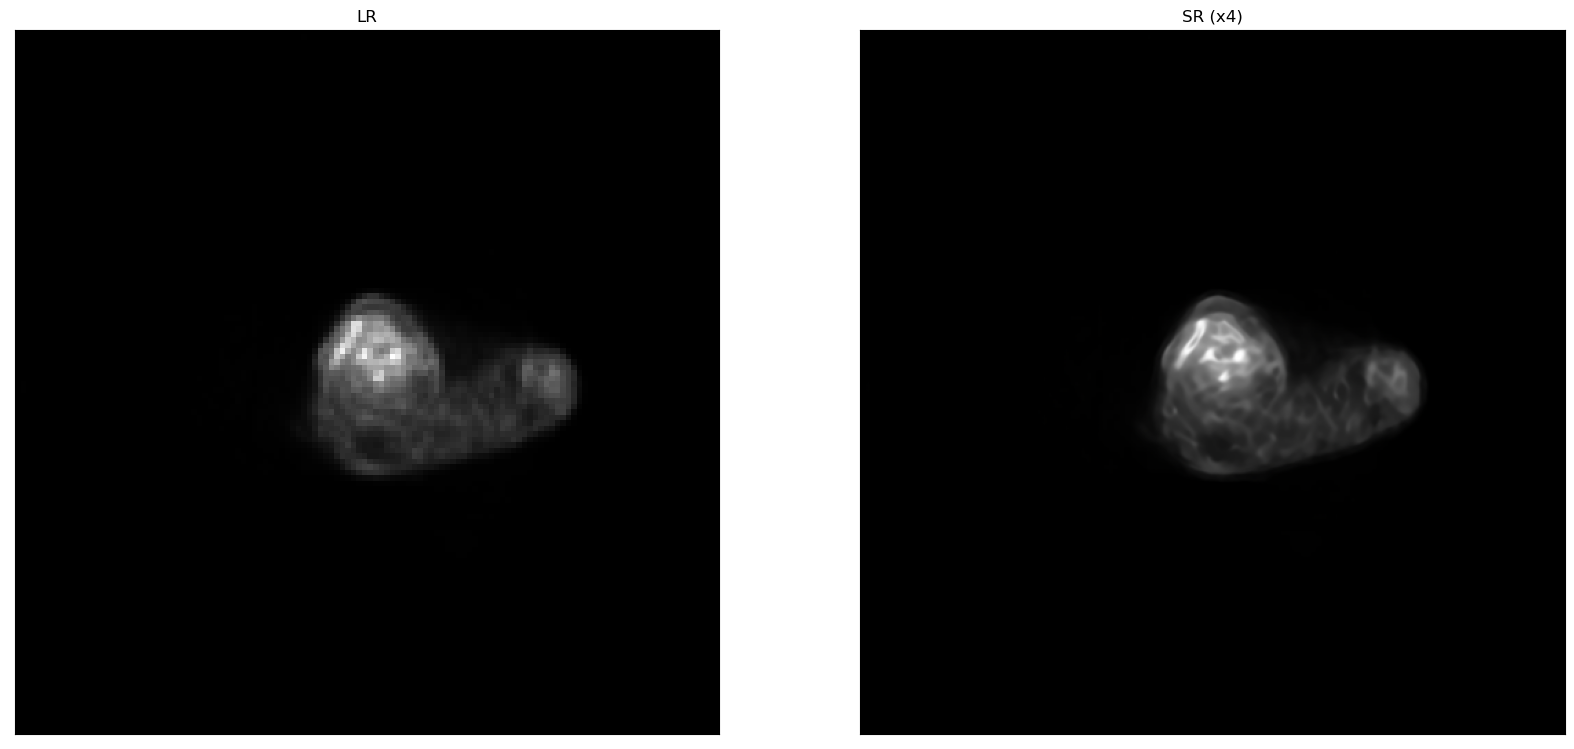

In [25]:
new_image = '../new_dataset/PET-radiomics-challenges-kaggle/Training/1.3.6.1.4.1.14519.5.2.1.1707.8040.10059866353110167322451781.png'
convert_and_plot(new_image)

In [26]:
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
import cv2
new_image = '/home/iga/super-resolution-master/new_dataset/Y-90/downscaled/0150x4.png'
# load the two input images
lr = np.array(Image.open(new_image).convert('RGB'))
sr = resolve_single(model, lr)
imageA = cv2.imread('/home/iga/super-resolution-master/new_dataset/Y-90/normal/0150.png')
imageB = np.array(sr)
# convert the images to grayscale
grayA = cv2.cvtColor(imageA, cv2.COLOR_RGB2GRAY)
grayB = cv2.cvtColor(imageB, cv2.COLOR_RGB2GRAY)

# compute the Structural Similarity Index (SSIM) between the two
# images, ensuring that the difference image is returned
(score, diff) = compare_ssim(grayA, grayB, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

SSIM: 0.9767681294912379
